# Part 7. Fix duplications

In the previous part, we've found that `tube` fuction may place some nodes two or more times. Here, we want to fix this defect.

In [1]:
# Rendering defaults
WIDTH = 5

In [2]:
import matplotlib.pyplot as plt
from typing import Any, Dict, List, Set, Union, Optional
from dataclasses import dataclass, field, replace
from enum import IntEnum
from random import randint

In [3]:
from operator import itemgetter

SiebenApp classes:

In [4]:
# One of two supported edge types
class EdgeType(IntEnum):
    BLOCKER = 1
    PARENT = 2

# Edge between two goals (wow, it doesn't use GoalId, right?)
@dataclass(frozen=True)
class Edge:
    source: int
    target: int
    type: EdgeType

# For legacy reasons, goal id may be either integer (real or pseudo goal) or string (pseudo goal only)
GoalId = Union[str, int]

# Single row of "render result" (well, actually, it's a single goal)
@dataclass(frozen=True)
class RenderRow:
    """Strongly typed rendered representation of a single goal."""

    goal_id: GoalId
    raw_id: int
    name: str
    is_open: bool
    is_switchable: bool
    edges: list[tuple[GoalId, EdgeType]]
    attrs: dict[str, str] = field(default_factory=lambda: {})

# A whole result of "rendering" (also suitable for result returned by a single request to goal tree)
@dataclass
class RenderResult:
    rows: list[RenderRow]
    edge_opts: dict[str, tuple[int, int, int]]
    select: tuple[GoalId, GoalId]
    node_opts: dict[GoalId, Any]
    roots: set[GoalId]
    index: dict[GoalId, int]

    def __init__(
        self,
        rows: list[RenderRow],
        edge_opts: Optional[dict[str, tuple[int, int, int]]] = None,
        select: Optional[tuple[GoalId, GoalId]] = None,
        node_opts: Optional[dict[GoalId, Any]] = None,
        roots: Optional[set[GoalId]] = None,
    ):
        self.rows = rows
        self.edge_opts = edge_opts or {}
        self.select = select or (0, 0)
        self.node_opts = node_opts or {}
        self.roots = roots or set()
        self.index = {row.goal_id: i for i, row in enumerate(rows)}

    def goals(self):
        return [
            (goal_id, attrs)
            for goal_id, attrs in self.node_opts.items()
            if isinstance(goal_id, int)
        ]

    def by_id(self, goal_id: GoalId) -> RenderRow:
        assert goal_id in self.index
        return self.rows[self.index[goal_id]]


In [5]:
def draw(rr: RenderResult, min_row: int = 0) -> None:
    xpos: Dict[int, int] = {}
    ypos: Dict[int, int] = {}
    for goal_id, attrs in rr.goals():
        row, col = attrs.get("row", None), attrs.get("col", None)
        # print(goal_id, row, col)
        xpos[goal_id] = col if col is not None else randint(0, 10)
        ypos[goal_id] = row if row is not None else randint(min_row, 10) 
    # print(xpos)
    # print(ypos)
    for row in rr.rows:
        row_id = row.goal_id
        for edge in row.edges:
            e = edge[0]
            plt.plot([xpos[row_id], xpos[e]], [ypos[row_id], ypos[e]], 'ro-')
        plt.text(xpos[row_id] + 0.1, ypos[row_id], row.name)
    tops = [row.goal_id for row in rr.rows if row.is_switchable]
    plt.plot([xpos[t] for t in tops], [ypos[t] for t in tops], 'bo')
    plt.draw()

A graph to render.

In [6]:
rr0 = RenderResult(rows=[RenderRow(goal_id=1, raw_id=1, name='node 1', is_open=True, is_switchable=False, edges=[(2, EdgeType.PARENT), (3, EdgeType.PARENT), (4, EdgeType.PARENT), (5, EdgeType.PARENT), (40, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=2, raw_id=2, name='node 2', is_open=True, is_switchable=True, edges=[(43, EdgeType.PARENT), (44, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=3, raw_id=3, name='node 3', is_open=True, is_switchable=False, edges=[(6, EdgeType.BLOCKER), (7, EdgeType.BLOCKER), (8, EdgeType.BLOCKER), (30, EdgeType.PARENT), (37, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=4, raw_id=4, name='node 4', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=5, raw_id=5, name='node 5', is_open=True, is_switchable=False, edges=[(6, EdgeType.PARENT), (7, EdgeType.PARENT), (8, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=6, raw_id=6, name='node 6', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=7, raw_id=7, name='node 7', is_open=True, is_switchable=False, edges=[(9, EdgeType.BLOCKER), (16, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=8, raw_id=8, name='node 8', is_open=False, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=9, raw_id=9, name='node 9', is_open=True, is_switchable=False, edges=[(10, EdgeType.PARENT), (11, EdgeType.PARENT), (12, EdgeType.PARENT), (13, EdgeType.PARENT), (14, EdgeType.PARENT), (15, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=10, raw_id=10, name='node 10', is_open=False, is_switchable=True, edges=[(51, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=11, raw_id=11, name='node 11', is_open=False, is_switchable=True, edges=[(51, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=12, raw_id=12, name='node 12', is_open=False, is_switchable=True, edges=[(51, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=13, raw_id=13, name='node 13', is_open=False, is_switchable=True, edges=[(51, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=14, raw_id=14, name='node 14', is_open=False, is_switchable=True, edges=[(51, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=15, raw_id=15, name='node 15', is_open=True, is_switchable=True, edges=[(51, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=16, raw_id=16, name='node 16', is_open=False, is_switchable=True, edges=[(17, EdgeType.PARENT), (18, EdgeType.PARENT), (19, EdgeType.PARENT), (20, EdgeType.PARENT), (24, EdgeType.PARENT), (25, EdgeType.PARENT), (26, EdgeType.PARENT), (27, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=17, raw_id=17, name='node 17', is_open=False, is_switchable=False, edges=[], attrs={}), RenderRow(goal_id=18, raw_id=18, name='node 18', is_open=False, is_switchable=False, edges=[(23, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=19, raw_id=19, name='node 19', is_open=False, is_switchable=False, edges=[(21, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=20, raw_id=20, name='node 20', is_open=False, is_switchable=False, edges=[(21, EdgeType.PARENT), (22, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=21, raw_id=21, name='node 21', is_open=False, is_switchable=False, edges=[(38, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=22, raw_id=22, name='node 22', is_open=False, is_switchable=False, edges=[], attrs={}), RenderRow(goal_id=23, raw_id=23, name='node 23', is_open=False, is_switchable=False, edges=[(38, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=24, raw_id=24, name='node 24', is_open=False, is_switchable=False, edges=[(18, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=25, raw_id=25, name='node 25', is_open=False, is_switchable=False, edges=[(18, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=26, raw_id=26, name='node 26', is_open=False, is_switchable=False, edges=[(18, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=27, raw_id=27, name='node 27', is_open=False, is_switchable=False, edges=[(18, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=28, raw_id=28, name='node 28', is_open=False, is_switchable=True, edges=[(29, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=29, raw_id=29, name='node 29', is_open=False, is_switchable=False, edges=[(45, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=30, raw_id=30, name='node 30', is_open=True, is_switchable=True, edges=[(31, EdgeType.PARENT), (32, EdgeType.PARENT), (33, EdgeType.PARENT), (34, EdgeType.PARENT), (35, EdgeType.PARENT), (36, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=31, raw_id=31, name='node 31', is_open=False, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=32, raw_id=32, name='node 32', is_open=False, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=33, raw_id=33, name='node 33', is_open=False, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=34, raw_id=34, name='node 34', is_open=False, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=35, raw_id=35, name='node 35', is_open=False, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=36, raw_id=36, name='node 36', is_open=False, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=37, raw_id=37, name='node 37', is_open=True, is_switchable=False, edges=[(9, EdgeType.PARENT), (16, EdgeType.PARENT), (28, EdgeType.PARENT), (42, EdgeType.PARENT), (46, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=38, raw_id=38, name='node 38', is_open=False, is_switchable=False, edges=[], attrs={}), RenderRow(goal_id=39, raw_id=39, name='node 39', is_open=False, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=40, raw_id=40, name='node 40', is_open=True, is_switchable=False, edges=[(39, EdgeType.PARENT), (41, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=41, raw_id=41, name='node 41', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=42, raw_id=42, name='node 42', is_open=False, is_switchable=True, edges=[(43, EdgeType.BLOCKER), (44, EdgeType.BLOCKER), (49, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=43, raw_id=43, name='node 43', is_open=False, is_switchable=False, edges=[], attrs={}), RenderRow(goal_id=44, raw_id=44, name='node 44', is_open=False, is_switchable=False, edges=[], attrs={}), RenderRow(goal_id=45, raw_id=45, name='node 45', is_open=False, is_switchable=False, edges=[], attrs={}), RenderRow(goal_id=46, raw_id=46, name='node 46', is_open=False, is_switchable=True, edges=[(47, EdgeType.PARENT), (48, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=47, raw_id=47, name='node 47', is_open=False, is_switchable=False, edges=[], attrs={}), RenderRow(goal_id=48, raw_id=48, name='node 48', is_open=False, is_switchable=False, edges=[], attrs={}), RenderRow(goal_id=49, raw_id=49, name='node 49', is_open=False, is_switchable=False, edges=[(50, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=50, raw_id=50, name='node 50', is_open=False, is_switchable=False, edges=[], attrs={}), RenderRow(goal_id=51, raw_id=51, name='node 51', is_open=False, is_switchable=False, edges=[], attrs={})], select=(1, 1), roots={1}, node_opts={1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}, 12: {}, 13: {}, 14: {}, 15: {}, 16: {}, 17: {}, 18: {}, 19: {}, 20: {}, 21: {}, 22: {}, 23: {}, 24: {}, 25: {}, 26:{}, 27: {}, 28: {}, 29: {}, 30: {}, 31: {}, 32: {}, 33: {}, 34: {}, 35: {}, 36: {}, 37: {}, 38: {}, 39: {}, 40: {}, 41: {}, 42: {}, 43: {}, 44: {}, 45: {}, 46: {}, 47: {}, 48: {}, 49: {}, 50: {}, 51: {}})

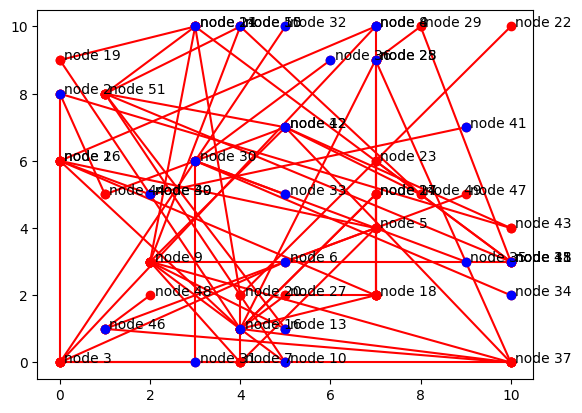

In [7]:
draw(rr0)

Old layering functions, for comparision.

In [ ]:
def add_if_not(m: Dict, m1: Dict) -> Dict:
    nm = dict(m)
    for k, v in m1.items():
        if nm.get(k, None) is None:
            nm[k] = v
    return nm

In order to reduce copy&paste between different steps, we'll introduce a new abstraction that holds all temporary values between steps.

In [53]:
@dataclass
class RenderStep:
    rr: RenderResult
    roots: List[int]
    layers: List[List[int]]

def pp(step: RenderStep):
    return [step.roots, step.layers]

In [48]:
def tube0(step: RenderStep):
    new_layer: List[int] = step.roots[:WIDTH]
    new_roots: List[int] = step.roots[len(new_layer):] + \
                            [e[0] for gid in new_layer for e in step.rr.by_id(gid).edges]
    new_opts: Dict[int, Dict] = {
        goal_id: add_if_not(opts, {
            "row": len(step.layers) if goal_id in new_layer else None,
            "col": new_layer.index(goal_id) if goal_id in new_layer else None
        })
        for goal_id, opts in step.rr.node_opts.items()
    }
    
    return RenderStep(
            RenderResult(step.rr.rows, node_opts=new_opts, select=step.rr.select, roots=step.rr.roots),
            new_roots,
            step.layers + [new_layer])

In [49]:
roots0 = list(rr0.roots)
layers0 = []

In [54]:
step_0_1 = tube0(RenderStep(rr0, roots0, layers0))
pp(step_0_1)

[[2, 3, 4, 5, 40], [[1]]]

What happened here:
1. Node with id 1 is put to the first layer.
2. Nodes with ids 2, 3, 4, 5 and 40 are now candidates for the new layer. All of them are connected to node 1 with edges of lenght 1.

## New functions

Almost same `tube`, but with tracking of added nodes.

In [55]:
def tube(step: RenderStep):
    new_layer: List[int] = step.roots[:WIDTH]
    new_roots: List[int] = step.roots[len(new_layer):] + \
                            [e[0] for gid in new_layer for e in step.rr.by_id(gid).edges]
    new_opts: Dict[int, Dict] = {
        goal_id: add_if_not(opts, {
            "row": len(step.layers) if goal_id in new_layer else None,
            "col": new_layer.index(goal_id) if goal_id in new_layer else None
        })
        for goal_id, opts in step.rr.node_opts.items()
    }
    # New logic: filter duplicates from new_roots
    new_layers = step.layers + [new_layer]
    already_added: Set[int] = {g for l in new_layers for g in l}
    filtered_roots: List[int] = []
    for g in new_roots:
        if g not in already_added:
            filtered_roots.append(g)
            already_added.add(g)
    # End of new logic
    
    return RenderStep(
            RenderResult(step.rr.rows, node_opts=new_opts, select=step.rr.select, roots=step.rr.roots),
            filtered_roots,
            new_layers)

In [56]:
step_1_1 = tube(RenderStep(rr0, roots0, layers0))
pp(step_1_1)

[[2, 3, 4, 5, 40], [[1]]]

### Next steps

Let's roll down and generate steps with both functions. We'll see when a difference appears.

In [57]:
step_0_2 = tube0(step_0_1)
step_1_2 = tube(step_1_1)
pp(step_0_2), pp(step_1_2)

([[43, 44, 6, 7, 8, 30, 37, 6, 7, 8, 39, 41], [[1], [2, 3, 4, 5, 40]]],
 [[43, 44, 6, 7, 8, 30, 37, 39, 41], [[1], [2, 3, 4, 5, 40]]])

Duplications filtered out: the second appearance of `6, 7, 8`.

In [58]:
step_0_3 = tube0(step_0_2)
step_1_3 = tube(step_1_2)
pp(step_0_3), pp(step_1_3)

([[30, 37, 6, 7, 8, 39, 41, 9, 16],
  [[1], [2, 3, 4, 5, 40], [43, 44, 6, 7, 8]]],
 [[30, 37, 39, 41, 9, 16], [[1], [2, 3, 4, 5, 40], [43, 44, 6, 7, 8]]])

Same here.

In [59]:
step_0_4 = tube0(step_0_3)
step_1_4 = tube(step_1_3)
pp(step_0_4), pp(step_1_4)

([[39, 41, 9, 16, 31, 32, 33, 34, 35, 36, 9, 16, 28, 42, 46, 9, 16],
  [[1], [2, 3, 4, 5, 40], [43, 44, 6, 7, 8], [30, 37, 6, 7, 8]]],
 [[16, 31, 32, 33, 34, 35, 36, 28, 42, 46, 10, 11, 12, 13, 14, 15],
  [[1], [2, 3, 4, 5, 40], [43, 44, 6, 7, 8], [30, 37, 39, 41, 9]]])

More and more changes between two functions. In the fixed version, we already got more compact result with nodes 39, 41 and 9 on layer 4. In the old version, there are 3 appearances of goals 9 and 16 in `roots` queue.

In [60]:
step_0_5 = tube0(step_0_4)
step_1_5 = tube(step_1_4)
pp(step_0_5), pp(step_1_5)

([[32,
   33,
   34,
   35,
   36,
   9,
   16,
   28,
   42,
   46,
   9,
   16,
   10,
   11,
   12,
   13,
   14,
   15,
   17,
   18,
   19,
   20,
   24,
   25,
   26,
   27],
  [[1],
   [2, 3, 4, 5, 40],
   [43, 44, 6, 7, 8],
   [30, 37, 6, 7, 8],
   [39, 41, 9, 16, 31]]],
 [[35, 36, 28, 42, 46, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 24, 25, 26, 27],
  [[1],
   [2, 3, 4, 5, 40],
   [43, 44, 6, 7, 8],
   [30, 37, 39, 41, 9],
   [16, 31, 32, 33, 34]]])

In [61]:
step_0_6 = tube0(step_0_5)
step_1_6 = tube(step_1_5)
pp(step_0_6), pp(step_1_6)

([[9,
   16,
   28,
   42,
   46,
   9,
   16,
   10,
   11,
   12,
   13,
   14,
   15,
   17,
   18,
   19,
   20,
   24,
   25,
   26,
   27],
  [[1],
   [2, 3, 4, 5, 40],
   [43, 44, 6, 7, 8],
   [30, 37, 6, 7, 8],
   [39, 41, 9, 16, 31],
   [32, 33, 34, 35, 36]]],
 [[10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 24, 25, 26, 27, 29, 49, 47, 48],
  [[1],
   [2, 3, 4, 5, 40],
   [43, 44, 6, 7, 8],
   [30, 37, 39, 41, 9],
   [16, 31, 32, 33, 34],
   [35, 36, 28, 42, 46]]])

In [62]:
step_0_7 = tube0(step_0_6)
step_1_7 = tube(step_1_6)
pp(step_0_7), pp(step_1_7)

([[9,
   16,
   10,
   11,
   12,
   13,
   14,
   15,
   17,
   18,
   19,
   20,
   24,
   25,
   26,
   27,
   10,
   11,
   12,
   13,
   14,
   15,
   17,
   18,
   19,
   20,
   24,
   25,
   26,
   27,
   29,
   43,
   44,
   49,
   47,
   48],
  [[1],
   [2, 3, 4, 5, 40],
   [43, 44, 6, 7, 8],
   [30, 37, 6, 7, 8],
   [39, 41, 9, 16, 31],
   [32, 33, 34, 35, 36],
   [9, 16, 28, 42, 46]]],
 [[15, 17, 18, 19, 20, 24, 25, 26, 27, 29, 49, 47, 48, 51],
  [[1],
   [2, 3, 4, 5, 40],
   [43, 44, 6, 7, 8],
   [30, 37, 39, 41, 9],
   [16, 31, 32, 33, 34],
   [35, 36, 28, 42, 46],
   [10, 11, 12, 13, 14]]])

The new structure is more compact by 1 layer already: node 46 is on the 6th level here, and on the 7th in the old result. Also, there's a significant amount of duplications in old `roots` (a whole sequence `10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 24, 25, 26, 27`).

In [63]:
step_0_8 = tube0(step_0_7)
step_1_8 = tube(step_1_7)
pp(step_0_8), pp(step_1_8)

([[13,
   14,
   15,
   17,
   18,
   19,
   20,
   24,
   25,
   26,
   27,
   10,
   11,
   12,
   13,
   14,
   15,
   17,
   18,
   19,
   20,
   24,
   25,
   26,
   27,
   29,
   43,
   44,
   49,
   47,
   48,
   10,
   11,
   12,
   13,
   14,
   15,
   17,
   18,
   19,
   20,
   24,
   25,
   26,
   27,
   51,
   51,
   51],
  [[1],
   [2, 3, 4, 5, 40],
   [43, 44, 6, 7, 8],
   [30, 37, 6, 7, 8],
   [39, 41, 9, 16, 31],
   [32, 33, 34, 35, 36],
   [9, 16, 28, 42, 46],
   [9, 16, 10, 11, 12]]],
 [[24, 25, 26, 27, 29, 49, 47, 48, 51, 23, 21, 22],
  [[1],
   [2, 3, 4, 5, 40],
   [43, 44, 6, 7, 8],
   [30, 37, 39, 41, 9],
   [16, 31, 32, 33, 34],
   [35, 36, 28, 42, 46],
   [10, 11, 12, 13, 14],
   [15, 17, 18, 19, 20]]])

In [64]:
step_0_9 = tube0(step_0_8)
step_1_9 = tube(step_1_8)
pp(step_0_9), pp(step_1_9)

([[19,
   20,
   24,
   25,
   26,
   27,
   10,
   11,
   12,
   13,
   14,
   15,
   17,
   18,
   19,
   20,
   24,
   25,
   26,
   27,
   29,
   43,
   44,
   49,
   47,
   48,
   10,
   11,
   12,
   13,
   14,
   15,
   17,
   18,
   19,
   20,
   24,
   25,
   26,
   27,
   51,
   51,
   51,
   51,
   51,
   51,
   23],
  [[1],
   [2, 3, 4, 5, 40],
   [43, 44, 6, 7, 8],
   [30, 37, 6, 7, 8],
   [39, 41, 9, 16, 31],
   [32, 33, 34, 35, 36],
   [9, 16, 28, 42, 46],
   [9, 16, 10, 11, 12],
   [13, 14, 15, 17, 18]]],
 [[49, 47, 48, 51, 23, 21, 22, 45],
  [[1],
   [2, 3, 4, 5, 40],
   [43, 44, 6, 7, 8],
   [30, 37, 39, 41, 9],
   [16, 31, 32, 33, 34],
   [35, 36, 28, 42, 46],
   [10, 11, 12, 13, 14],
   [15, 17, 18, 19, 20],
   [24, 25, 26, 27, 29]]])

In [65]:
step_0_10 = tube0(step_0_9)
step_1_10 = tube(step_1_9)
pp(step_0_10), pp(step_1_10)

([[27,
   10,
   11,
   12,
   13,
   14,
   15,
   17,
   18,
   19,
   20,
   24,
   25,
   26,
   27,
   29,
   43,
   44,
   49,
   47,
   48,
   10,
   11,
   12,
   13,
   14,
   15,
   17,
   18,
   19,
   20,
   24,
   25,
   26,
   27,
   51,
   51,
   51,
   51,
   51,
   51,
   23,
   21,
   21,
   22,
   18,
   18,
   18],
  [[1],
   [2, 3, 4, 5, 40],
   [43, 44, 6, 7, 8],
   [30, 37, 6, 7, 8],
   [39, 41, 9, 16, 31],
   [32, 33, 34, 35, 36],
   [9, 16, 28, 42, 46],
   [9, 16, 10, 11, 12],
   [13, 14, 15, 17, 18],
   [19, 20, 24, 25, 26]]],
 [[21, 22, 45, 50, 38],
  [[1],
   [2, 3, 4, 5, 40],
   [43, 44, 6, 7, 8],
   [30, 37, 39, 41, 9],
   [16, 31, 32, 33, 34],
   [35, 36, 28, 42, 46],
   [10, 11, 12, 13, 14],
   [15, 17, 18, 19, 20],
   [24, 25, 26, 27, 29],
   [49, 47, 48, 51, 23]]])

In [66]:
step_0_11 = tube0(step_0_10)
step_1_11 = tube(step_1_10)
pp(step_0_11), pp(step_1_11)

([[14,
   15,
   17,
   18,
   19,
   20,
   24,
   25,
   26,
   27,
   29,
   43,
   44,
   49,
   47,
   48,
   10,
   11,
   12,
   13,
   14,
   15,
   17,
   18,
   19,
   20,
   24,
   25,
   26,
   27,
   51,
   51,
   51,
   51,
   51,
   51,
   23,
   21,
   21,
   22,
   18,
   18,
   18,
   18,
   51,
   51,
   51,
   51],
  [[1],
   [2, 3, 4, 5, 40],
   [43, 44, 6, 7, 8],
   [30, 37, 6, 7, 8],
   [39, 41, 9, 16, 31],
   [32, 33, 34, 35, 36],
   [9, 16, 28, 42, 46],
   [9, 16, 10, 11, 12],
   [13, 14, 15, 17, 18],
   [19, 20, 24, 25, 26],
   [27, 10, 11, 12, 13]]],
 [[],
  [[1],
   [2, 3, 4, 5, 40],
   [43, 44, 6, 7, 8],
   [30, 37, 39, 41, 9],
   [16, 31, 32, 33, 34],
   [35, 36, 28, 42, 46],
   [10, 11, 12, 13, 14],
   [15, 17, 18, 19, 20],
   [24, 25, 26, 27, 29],
   [49, 47, 48, 51, 23],
   [21, 22, 45, 50, 38]]])

That's it. In the new structure, we've already finished now. In the old structure, a queue is catastrophically long yet. Compare visualization for the current moment.

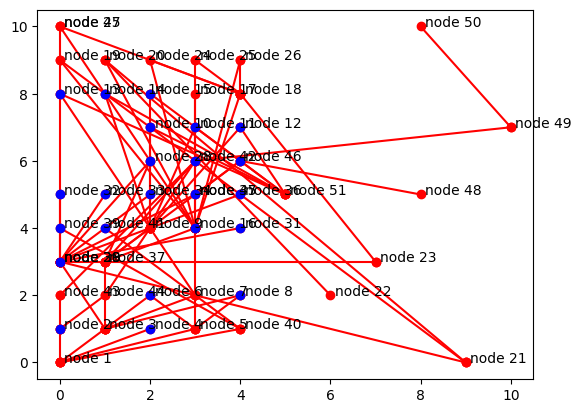

In [69]:
draw(step_0_11.rr)

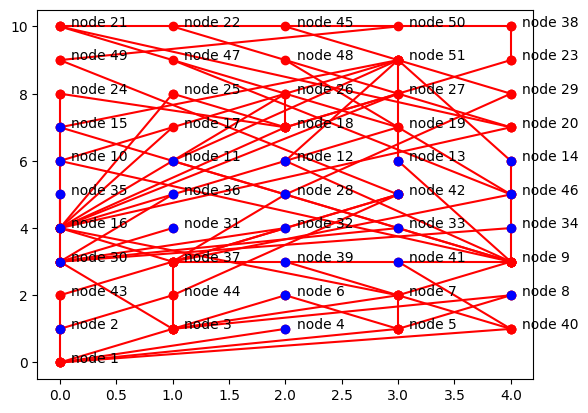

In [70]:
draw(step_1_11.rr)

### Finish the old rendering function

Okay, we know that the old rendering function would finish its work anyway. Let's roll to its end and compare results again.

In [75]:
step_0_12 = tube0(step_0_11)
step_0_13 = tube0(step_0_12)
step_0_14 = tube0(step_0_13)
step_0_15 = tube0(step_0_14)
step_0_16 = tube0(step_0_15)
step_0_17 = tube0(step_0_16)
step_0_18 = tube0(step_0_17)
step_0_19 = tube0(step_0_18)
step_0_20 = tube0(step_0_19)
step_0_21 = tube0(step_0_20)
step_0_22 = tube0(step_0_21)
step_0_23 = tube0(step_0_22)
step_0_24 = tube0(step_0_23)
step_0_25 = tube0(step_0_24)
step_0_26 = tube0(step_0_25)
pp(step_0_26)

[[38,
  38,
  23,
  23,
  23,
  23,
  38,
  38,
  38,
  23,
  23,
  23,
  23,
  38,
  38,
  38,
  23,
  23,
  23,
  23],
 [[1],
  [2, 3, 4, 5, 40],
  [43, 44, 6, 7, 8],
  [30, 37, 6, 7, 8],
  [39, 41, 9, 16, 31],
  [32, 33, 34, 35, 36],
  [9, 16, 28, 42, 46],
  [9, 16, 10, 11, 12],
  [13, 14, 15, 17, 18],
  [19, 20, 24, 25, 26],
  [27, 10, 11, 12, 13],
  [14, 15, 17, 18, 19],
  [20, 24, 25, 26, 27],
  [29, 43, 44, 49, 47],
  [48, 10, 11, 12, 13],
  [14, 15, 17, 18, 19],
  [20, 24, 25, 26, 27],
  [51, 51, 51, 51, 51],
  [51, 23, 21, 21, 22],
  [18, 18, 18, 18, 51],
  [51, 51, 51, 51, 51],
  [23, 21, 21, 22, 18],
  [18, 18, 18, 45, 50],
  [51, 51, 51, 51, 51],
  [51, 23, 21, 21, 22],
  [18, 18, 18, 18, 38]]]

Node 38 is the last placed one. We could finish here, in theory. But we still have non-empty `roots` queue and have to roll more, until it's exhausted.

In [81]:
step_0_27 = tube0(step_0_26)
step_0_28 = tube0(step_0_27)
step_0_29 = tube0(step_0_28)
step_0_30 = tube0(step_0_29)
step_0_31 = tube0(step_0_30)
step_0_32 = tube0(step_0_31)
step_0_33 = tube0(step_0_32)
pp(step_0_33)

[[],
 [[1],
  [2, 3, 4, 5, 40],
  [43, 44, 6, 7, 8],
  [30, 37, 6, 7, 8],
  [39, 41, 9, 16, 31],
  [32, 33, 34, 35, 36],
  [9, 16, 28, 42, 46],
  [9, 16, 10, 11, 12],
  [13, 14, 15, 17, 18],
  [19, 20, 24, 25, 26],
  [27, 10, 11, 12, 13],
  [14, 15, 17, 18, 19],
  [20, 24, 25, 26, 27],
  [29, 43, 44, 49, 47],
  [48, 10, 11, 12, 13],
  [14, 15, 17, 18, 19],
  [20, 24, 25, 26, 27],
  [51, 51, 51, 51, 51],
  [51, 23, 21, 21, 22],
  [18, 18, 18, 18, 51],
  [51, 51, 51, 51, 51],
  [23, 21, 21, 22, 18],
  [18, 18, 18, 45, 50],
  [51, 51, 51, 51, 51],
  [51, 23, 21, 21, 22],
  [18, 18, 18, 18, 38],
  [38, 38, 23, 23, 23],
  [23, 38, 38, 38, 23],
  [23, 23, 23, 38, 38],
  [38, 23, 23, 23, 23],
  [38, 38, 38, 38, 38],
  [38, 38, 38, 38, 38],
  [38, 38]]]

We've finished only now! How would a result look? Again, compare two rendered graphs.

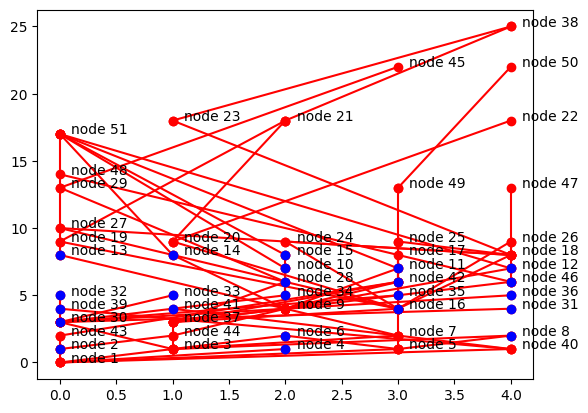

In [82]:
draw(step_0_33.rr)

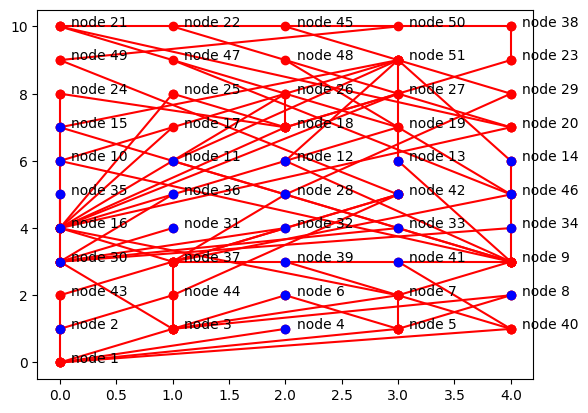

In [83]:
draw(step_1_11.rr)

### Compare metrics for both results

Just to feed our curiosity, let's use some metrics from previous chapters for both rendered results.

In [ ]:
from collections import Counter

In [ ]:
def duplications(step: RenderStep):
    c = Counter([g for l in step.layers for g in l])
    return {k: v for k, v in c.items() if v > 1}

In [85]:
duplications(step_1_11), duplications(step_0_33)

({},
 {43: 2,
  44: 2,
  6: 2,
  7: 2,
  8: 2,
  9: 3,
  16: 3,
  10: 3,
  11: 3,
  12: 3,
  13: 3,
  14: 3,
  15: 3,
  17: 3,
  18: 15,
  19: 3,
  20: 3,
  24: 3,
  25: 3,
  26: 3,
  27: 3,
  51: 18,
  23: 15,
  21: 6,
  22: 3,
  38: 21})

Amazing: **21** copies of node 38, **18** copies of node 51, and **15** copies of nodes 18 and 23!

In [86]:
def sign(x):
    return 0 if x == 0 else (1 if x > 0 else -1)

def force(vec, k):
    return sign(vec) * k * (abs(vec) - 1) * (abs(vec) - 1)

In [87]:
def energy(step: RenderStep):
    goal_layers = {t[0]: t[1]['row'] for t in step.rr.goals()}
    goal_connects = {g_id: [] for g_id in goal_layers}
    for row in step.rr.rows:
        for e in row.edges:
            my_id = row.goal_id
            my_layer = goal_layers[my_id]
            strength = 1.0 if e[1] == EdgeType.PARENT else 0.6
            its_id = e[0]
            its_layer = goal_layers[its_id]
            goal_connects[my_id].append((its_id, its_layer - my_layer, strength, force(its_layer - my_layer, strength)))
            goal_connects[e[0]].append((my_id, my_layer - its_layer, strength, force(my_layer - its_layer, strength)))

    forces = {k: sum(t[-1] for t in v) for k, v in goal_connects.items()}
    total_energy = sum(abs(v) for v in forces.values())
    max_force = max([abs(v) for v in forces.values()])
    return forces, total_energy, max_force

In [88]:
_, e0, max0 = energy(step_0_33)
_, e1, max1 = energy(step_1_11)

e0, e1, max0, max1

(1695.6000000000004, 239.2, 293.4, 51.4)

Overall comparison shows us a great effect of algorithm improvement:

| Metric | Old algo | Fixed algo |
|---|---|---|
| Iterations | 33 | 11 |
| Layers (rendered) | 26 | 11 |
| Max duplications | 21 | 0 |
| Graph energy | 1695.6 | 239.2 |
| Max edge energy | 293.4 | 51.4 |

## Next steps

While a new algorithm produces more compact result, it's still not free of bugs. Moreover, an old defect has become more visible now. We pack nodes into layers without any attention to potential edges between them! Take a look at the topmost layer in the rendered `step_1_11`. There's an edge `22->38`, and it has become horizontal. In the old result (`step_0_33`) this edge can be seen more clearly.

Therefore, our next step should improve behavior in node placement. We cannot eagerly consume as many nodes as allowed. There should be some kind of edge-based control.